# Comparison of similar matflow-damask workflows

This notebook is intended as a guide for comparison of matflow workflows with only one diffrent variable.
For example, slight variation of equiaxed microstructure for two crystal plasticity models with the same texture, or varying texture for two models with identical microstructure.

In [2]:
# Firstly, load in the required python libraries and functions:
# libraries and functions from the web:
import numpy as np
from matflow import load_workflow
import pickle
from cycler import cycler
import matplotlib.pyplot as plt
# libraries and functions local to this repository:
from utils import import_diff_params
from lattice_strain import lattice_strain
from plotting import plot_latticestrain
from plotting import plot_truestrain_peakint
from plotting import plot_lattice_strain_dist_inc

For this post-processing objective, we need to load in datasets from multiple diffrent matflow workflows.

However, for workflows containing large simulation result data (>20Gbs), **we need to restrict import of data to one use if possible**:

In [3]:
# define path to completed matflow workflow directories containing workflow.hdf5 files...
workflow_dir_1 = "/mnt/iusers01/jf01/y15576gb/\
postprocessing/\
028_Ti64_TIFUN-T4_TD_880C_DeformY64x_1mms-1_2023-04-04-102059/"

workflow_dir_2 = "/mnt/iusers01/jf01/y15576gb/\
postprocessing/\
034_Ti64_TIFUN-T4_TD_910C_DeformY64x_1mms-1_2023-03-14-113312/"

workflow_dir_3 = "/mnt/iusers01/jf01/y15576gb/\
postprocessing/\
011_Ti64_TIFUN-T4_TD_950C_DeformY64x_1mms-1_2023-04-03-141901/"
workflow_dirs = [workflow_dir_1, workflow_dir_2, workflow_dir_3]


In [8]:
workflow_dirs[0][64:-37]

'880C'

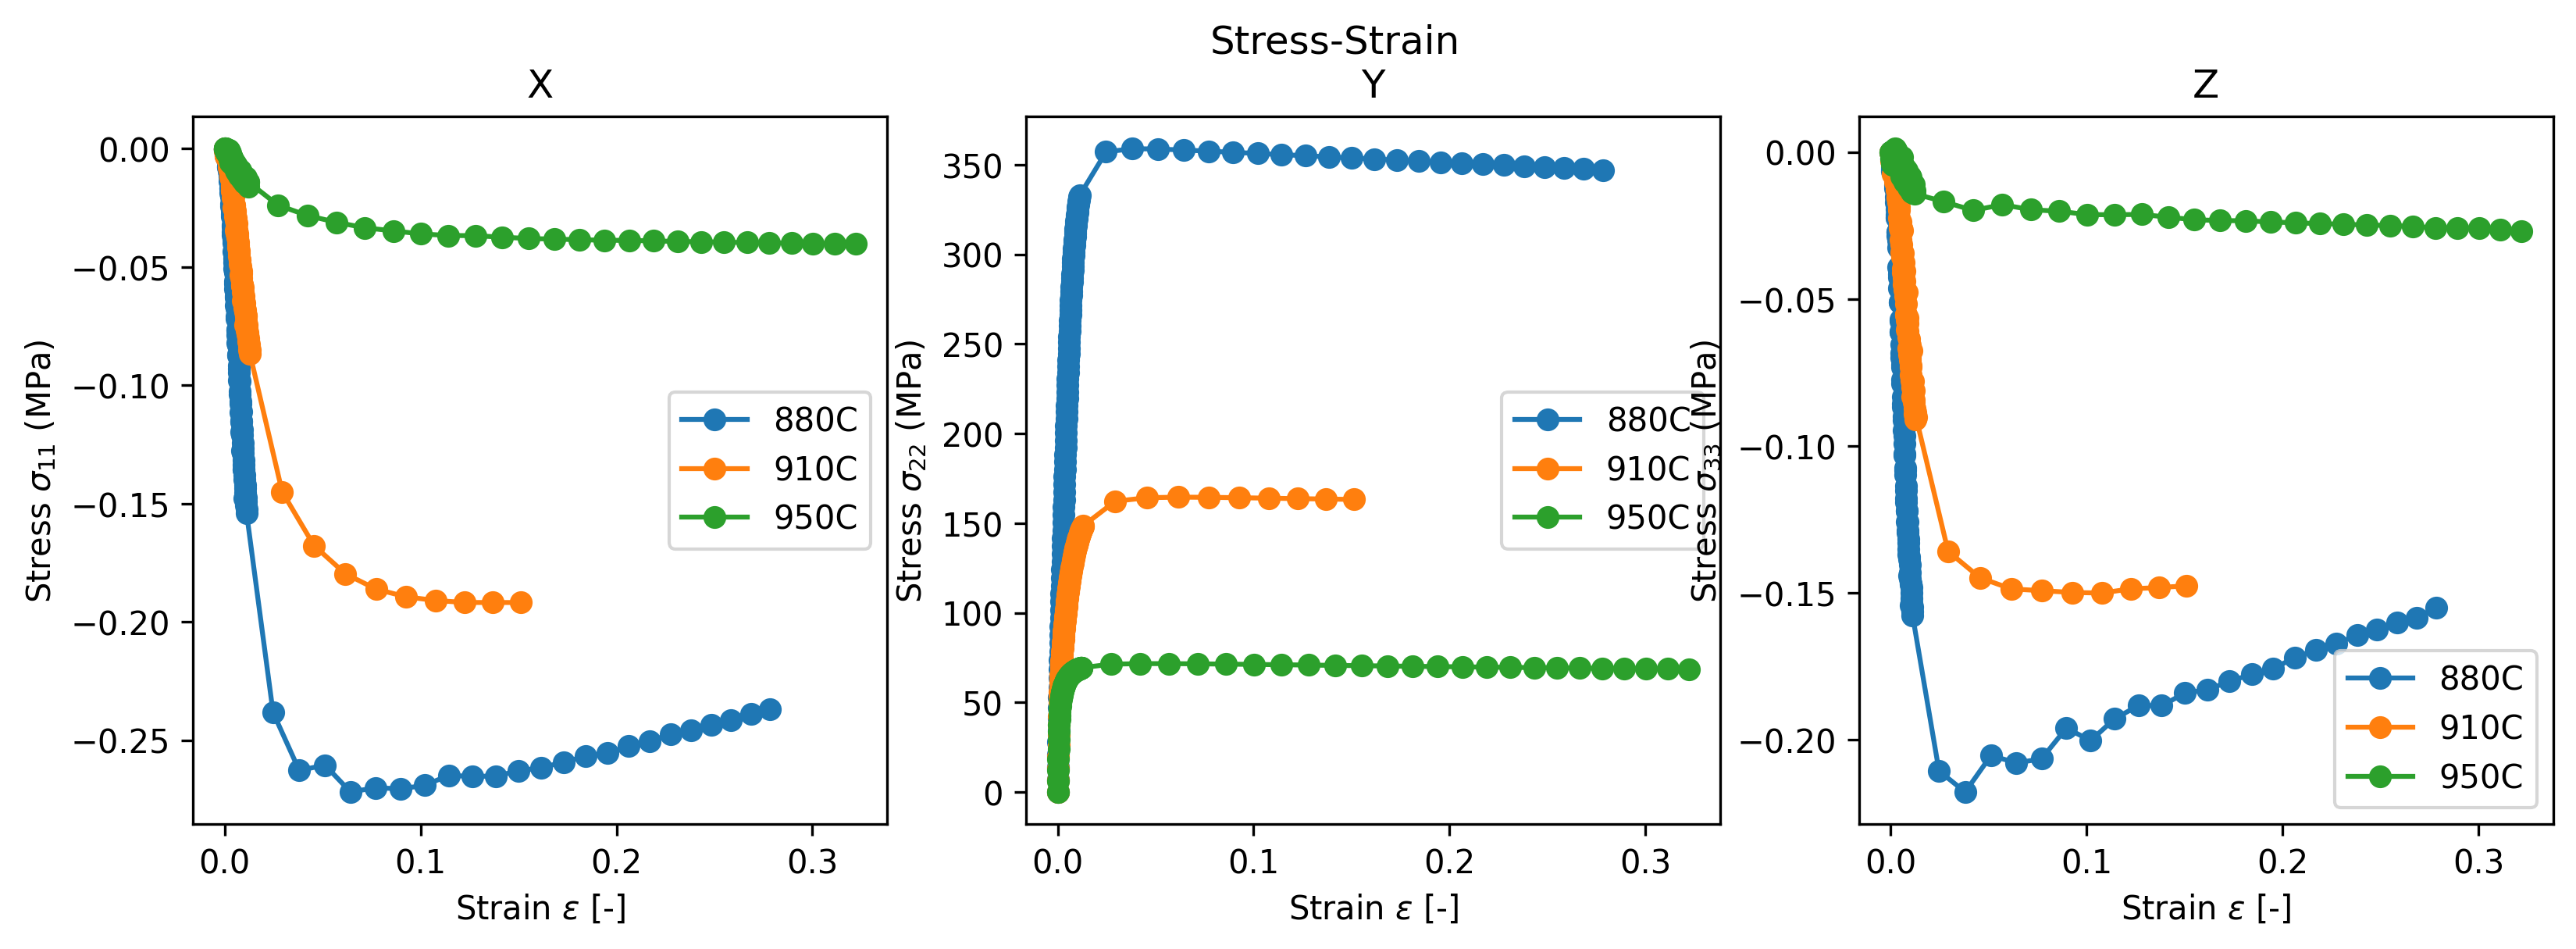

In [11]:
%matplotlib inline

fig, axs = plt.subplots(1,3, figsize=(13, 4), dpi=300, facecolor='w')
fig.suptitle('Stress-Strain')

for i, axis in enumerate(["X", "Y", "Z"]): # loop over axes directions
    for workflow_dir in workflow_dirs:
        stress_strain = pickle.load(open(workflow_dir+'stress_strain.pkl', 'rb'))
    
        stress = stress_strain[axis]['stress']
        strain = stress_strain[axis]['strain']

        axs[i].plot(strain, stress, linestyle='solid', marker='o', label=workflow_dir[64:-37])
        axs[i].title.set_text(f"{axis}")
        axs[i].set_facecolor("white")
        axs[i].set_xlabel(f"Strain $\epsilon$ [-]")
        axs[i].set_ylabel(f"Stress $\sigma_{{{str(i+1)}{str(i+1)}}}$ (MPa)")
        axs[i].legend()